# Imports

In [2]:
import pandas as pd
from pathlib import Path
import os
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

C:\Users\Luyza\AppData\Local\Temp\ipykernel_11604\157848297.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Obtenção dos dados

In [3]:
# Listar arquivos no diretório acima
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)

In [4]:
Y = df_raw[['SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']]
X = df_raw.iloc[:, 7:]

# Algoritmo PLSR

In [17]:
def optimise_pls_cv(X, y, n_comp, plot_components=True, max_iter=100):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin)
    stdout.write("\n")
    
    if plot_components:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color='blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    rmse_c = np.sqrt(mean_squared_error(y, y_c))
    rmse_cv = np.sqrt(mean_squared_error(y, y_cv))
    
    rpd = y.std() / np.sqrt(np.min(mse))
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('RMSE calib: %5.3f' % rmse_c)
    print('RMSE CV: %5.3f' % rmse_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    print('RPD: %5.3f' % rpd)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Measured')
 
        plt.show()
 
    return

# PLSR - Raw

In [19]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X = df_raw.iloc[:, 7:].values
# Get wavelengths
wl = np.arange(350,2500,1)

100% completed
Suggested number of components:  8



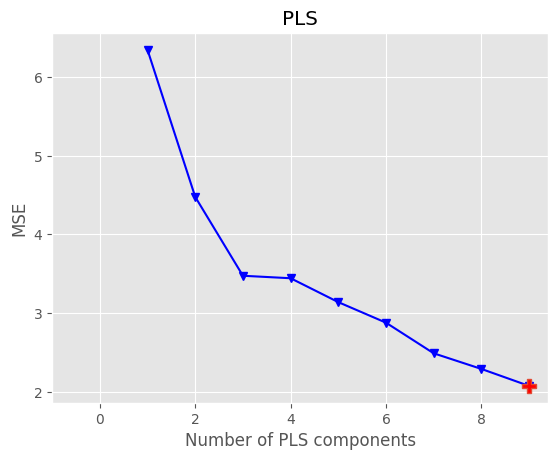

R2 calib: 0.779
R2 CV: 0.669
RMSE calib: 1.176
RMSE CV: 1.440
MSE calib: 1.383
MSE CV: 2.075
RPD: 1.738


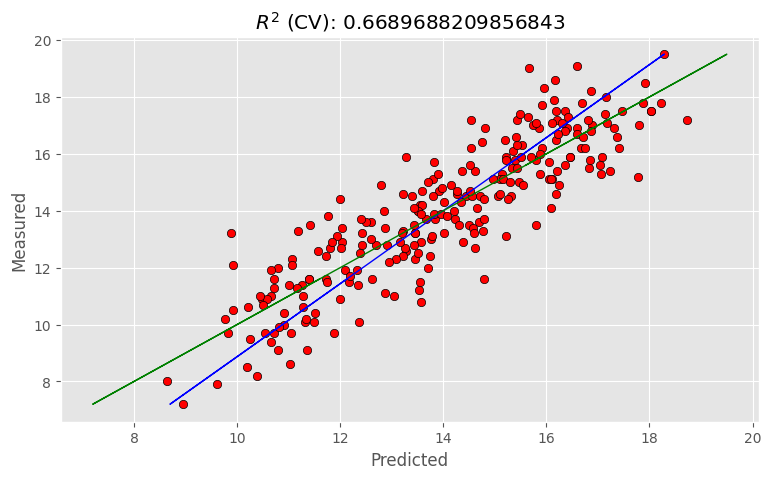

In [26]:
optimise_pls_cv(X,y_sst, 10, plot_components=True)

100% completed
Suggested number of components:  16



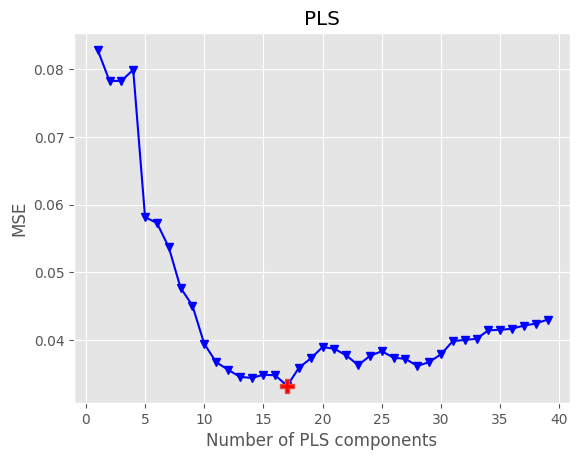

R2 calib: 0.833
R2 CV: 0.537
RMSE calib: 0.109
RMSE CV: 0.182
MSE calib: 0.012
MSE CV: 0.033
RPD: 1.470


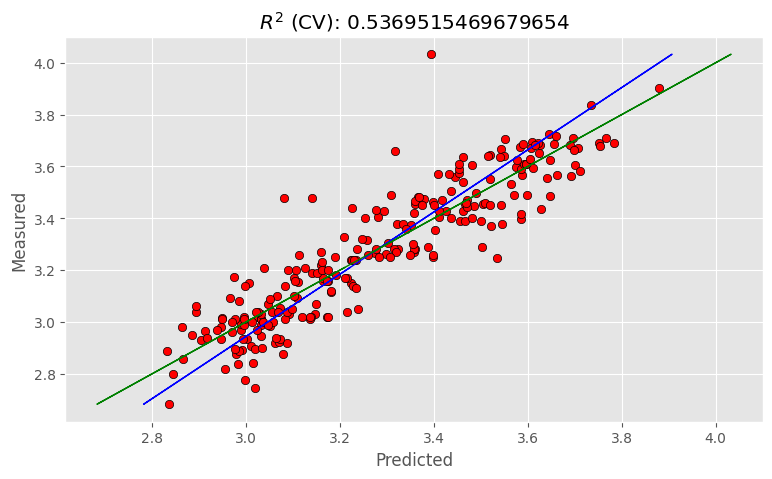

In [31]:
optimise_pls_cv(X,y_ph, 40, plot_components=True)

100% completed
Suggested number of components:  26



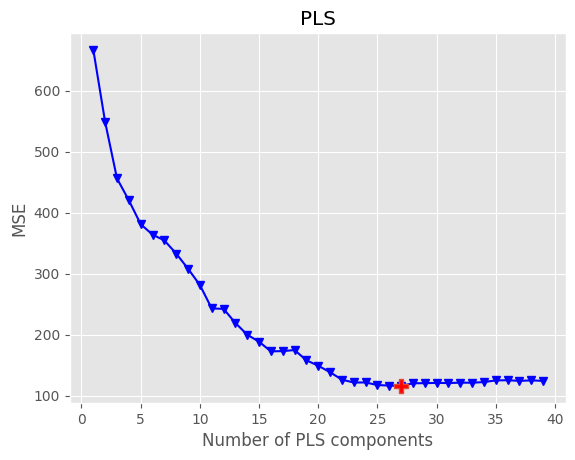

R2 calib: 0.983
R2 CV: 0.798
RMSE calib: 3.077
RMSE CV: 10.758
MSE calib: 9.466
MSE CV: 115.738
RPD: 2.225


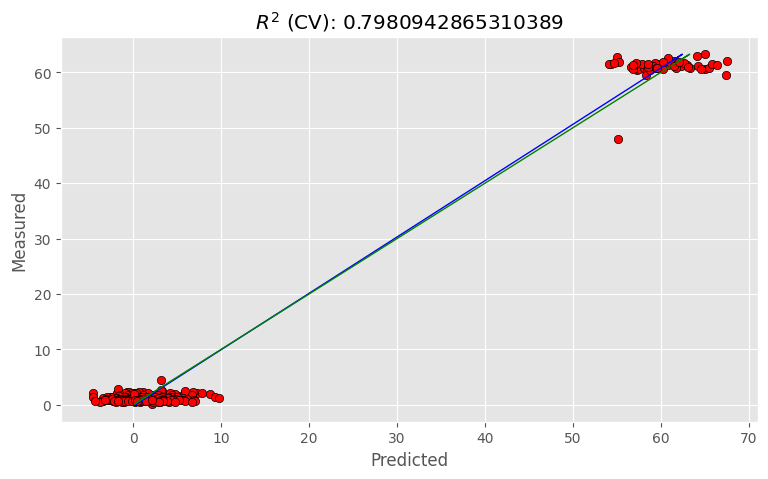

In [22]:
optimise_pls_cv(X,y_at, 40, plot_components=True)

100% completed
Suggested number of components:  14



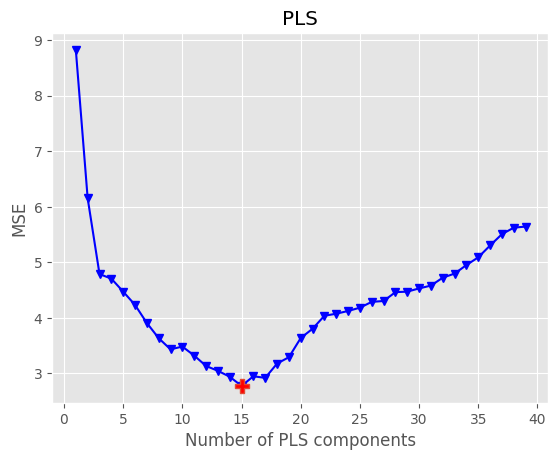

R2 calib: 0.837
R2 CV: 0.679
RMSE calib: 1.187
RMSE CV: 1.666
MSE calib: 1.410
MSE CV: 2.775
RPD: 1.766


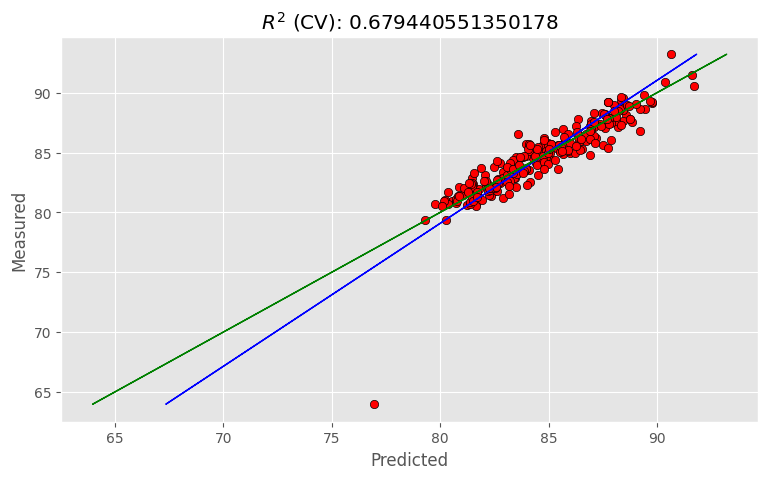

In [23]:
optimise_pls_cv(X,y_ubu, 40, plot_components=True)

100% completed
Suggested number of components:  14



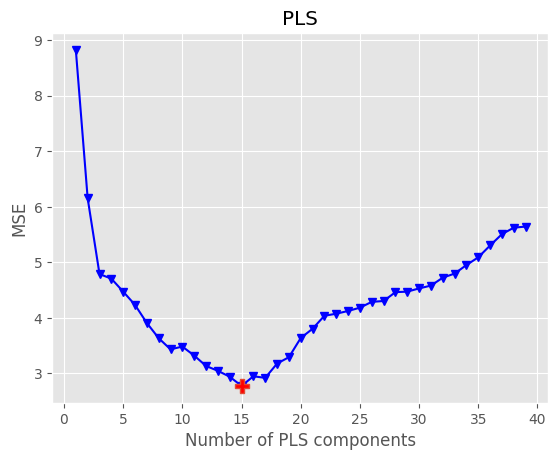

R2 calib: 0.837
R2 CV: 0.679
RMSE calib: 1.187
RMSE CV: 1.666
MSE calib: 1.410
MSE CV: 2.775
RPD: 1.766


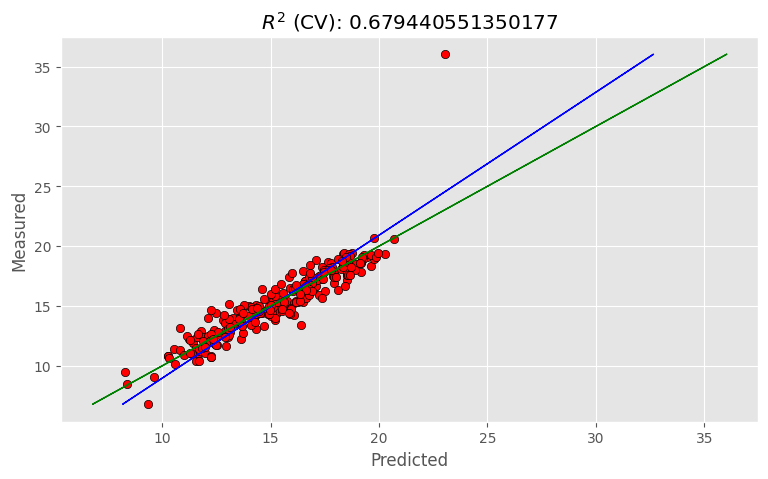

In [24]:
optimise_pls_cv(X,y_ubs, 40, plot_components=True)

# PLSR - MSC

In [11]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X_msc = df_msc.values
# Get wavelengths
wl = np.arange(350,2500,1)

100% completed
Suggested number of components:  13



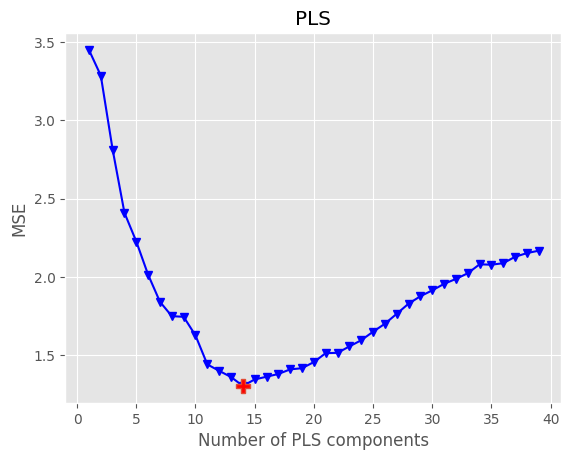

R2 calib: 0.904
R2 CV: 0.792
RMSE calib: 0.775
RMSE CV: 1.142
MSE calib: 0.601
MSE CV: 1.304
RPD: 2.192


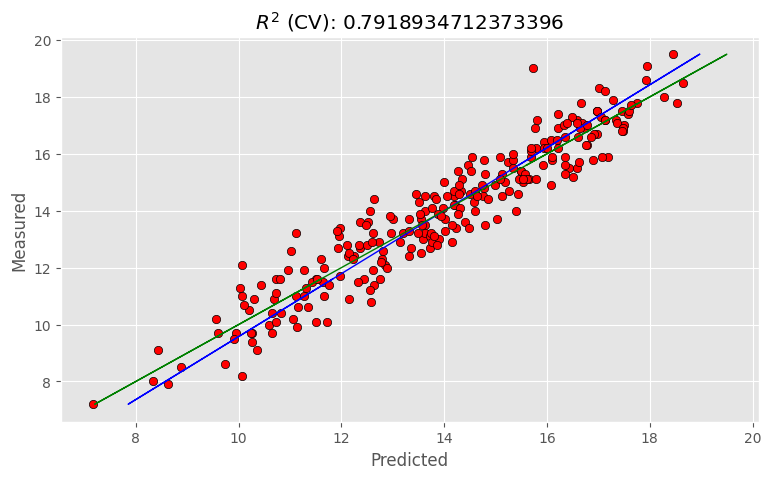

In [12]:
optimise_pls_cv(X_msc,y_sst, 40, plot_components=True)

100% completed
Suggested number of components:  20



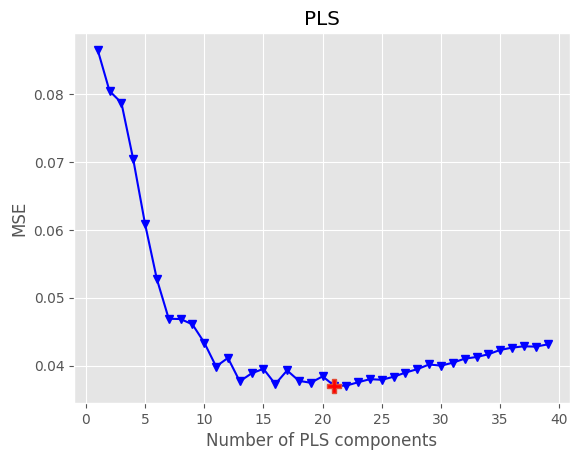

R2 calib: 0.921
R2 CV: 0.485
RMSE calib: 0.075
RMSE CV: 0.192
MSE calib: 0.006
MSE CV: 0.037
RPD: 1.393


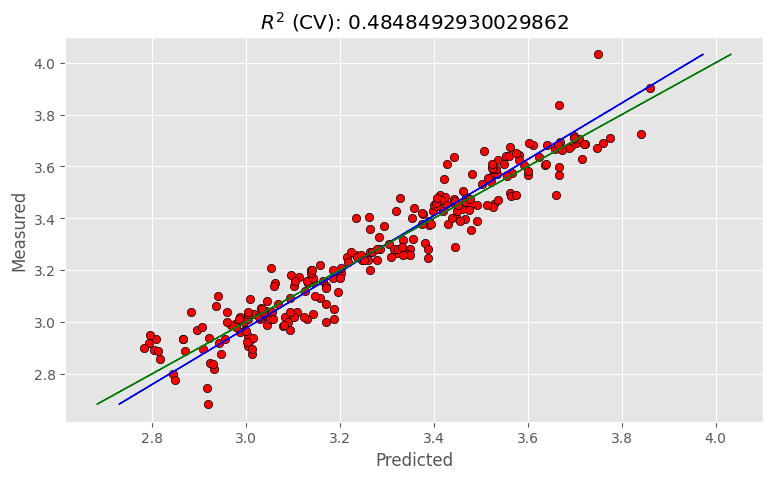

In [13]:
optimise_pls_cv(X_msc,y_ph, 40, plot_components=True)

100% completed
Suggested number of components:  20



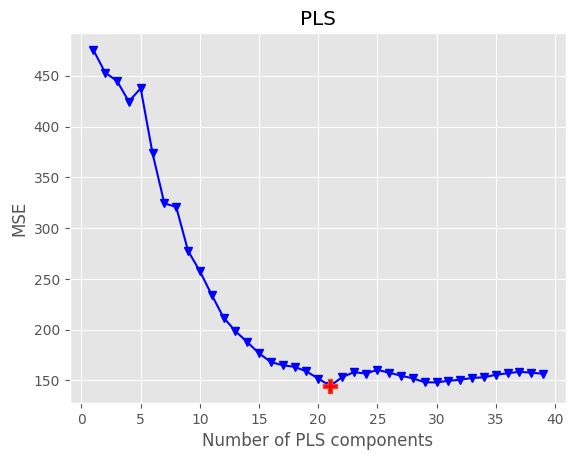

R2 calib: 0.969
R2 CV: 0.748
RMSE calib: 4.227
RMSE CV: 12.021
MSE calib: 17.864
MSE CV: 144.510
RPD: 1.992


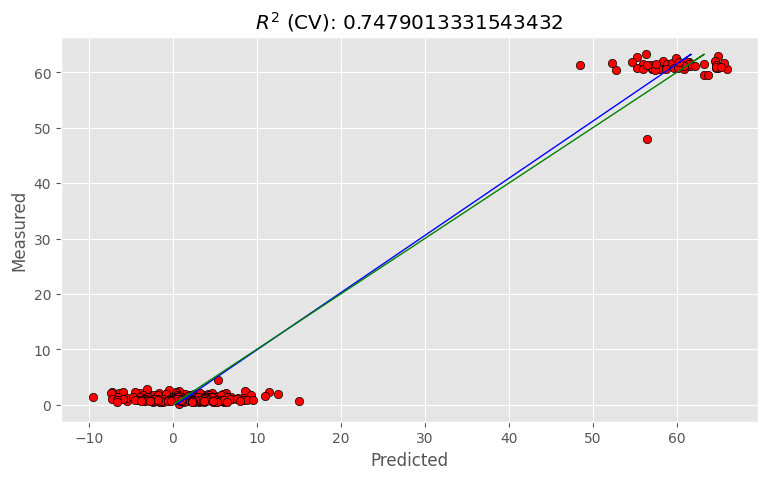

In [14]:
optimise_pls_cv(X_msc,y_at, 40, plot_components=True)

100% completed
Suggested number of components:  12



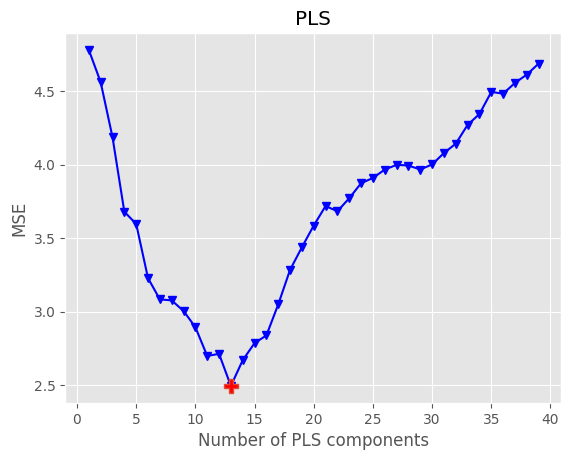

R2 calib: 0.843
R2 CV: 0.712
RMSE calib: 1.167
RMSE CV: 1.579
MSE calib: 1.361
MSE CV: 2.495
RPD: 1.863


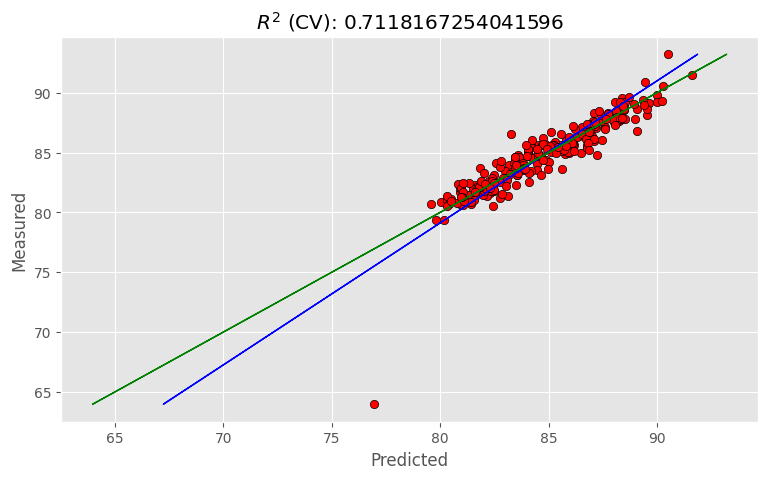

In [15]:
optimise_pls_cv(X_msc,y_ubu, 40, plot_components=True)

100% completed
Suggested number of components:  12



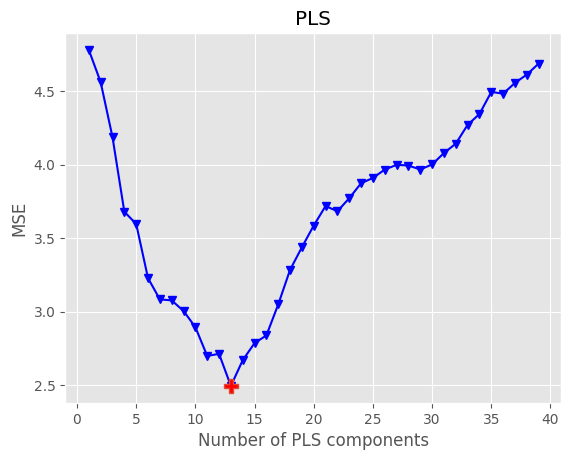

R2 calib: 0.843
R2 CV: 0.712
RMSE calib: 1.167
RMSE CV: 1.579
MSE calib: 1.361
MSE CV: 2.495
RPD: 1.863


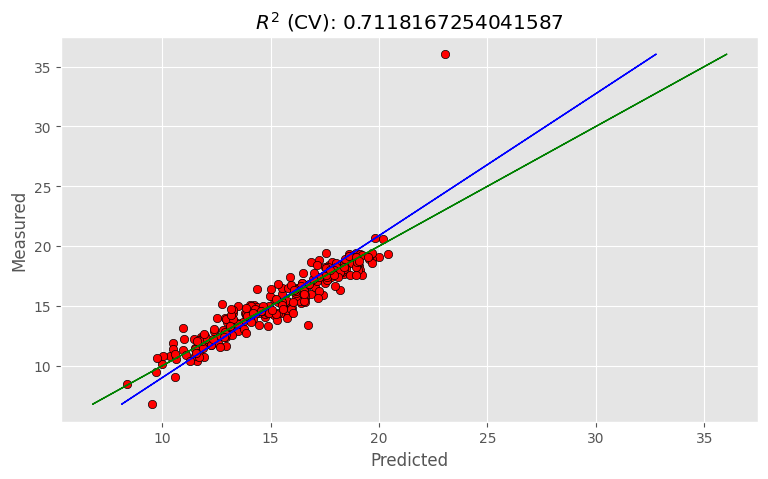

In [16]:
optimise_pls_cv(X_msc,y_ubs, 40, plot_components=True)

# PLSR - SNV

In [169]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X = df_snv.values
# Get wavelengths
wl = np.arange(350,2500,1)

100% completed
Suggested number of components:  7



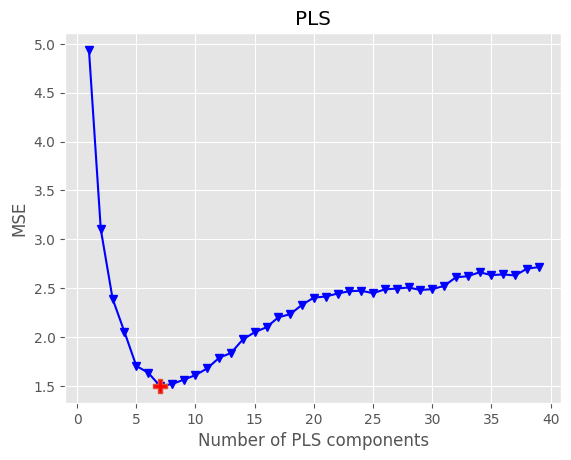

R2 calib: 0.851
R2 CV: 0.761
RMSE calib: 0.965
RMSE CV: 1.225
MSE calib: 0.932
MSE CV: 1.500
RPD: 2.044


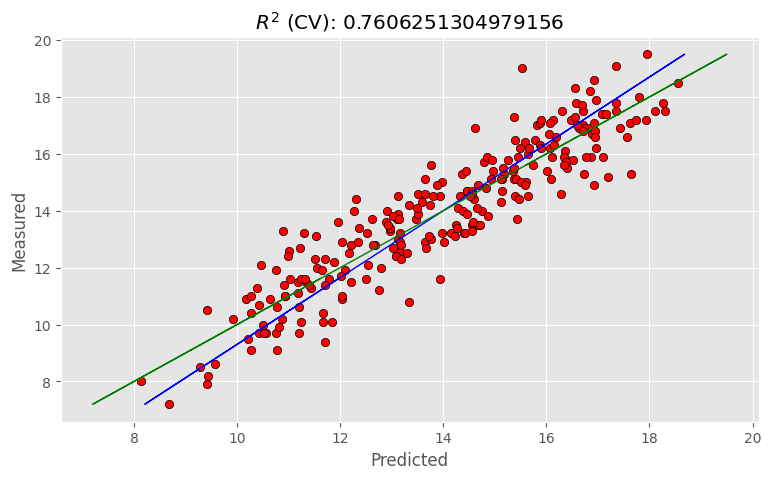

In [171]:
optimise_pls_cv(X,y_sst, 40, plot_components=True)

In [ ]:
optimise_pls_cv(X,y_, 40, plot_components=True)

# PLSR - SAVGOL

In [170]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X = df_sg.values
# Get wavelengths
wl = np.arange(350,2500,1)